In [1]:
import numpy as np
from qutip import destroy, basis, mesolve,liouvillian,steadystate,correlation_2op_1t,correlation_3op_1t,correlation_2op_2t,correlation_3op_2t,spectrum_correlation_fft,spectrum
import scipy
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from scipy.integrate import quad, odeint

# Gaussian pulse

In [2]:
def gaussian_pulse(t, α_0,tau_0,t_offset):
    return (α_0/ np.sqrt(2*np.pi*tau_0**2)) * np.exp(-(t-t_offset)**2 / (2*tau_0**2))

# Population time evolution

In [3]:
def TLS_populations(Δσ_0, γσ_0, α_0, tau_0, t_offset, tlist):
    
    σ = destroy(2)
    H0 = Δσ_0 * σ.dag() * σ
    H1 = 1/2 * (σ.dag() + σ)
    H = [H0, [H1, lambda t, args: gaussian_pulse(t, α_0, tau_0, t_offset)]]
    c_ops = [np.sqrt(γσ_0) * σ]
    psi0 = basis(2, 0)
    result = mesolve(H, psi0, tlist, c_ops, [σ.dag() * σ])
    excited_state_pop=result.expect[0]

    return excited_state_pop

In [4]:
#parameters

##2LS
Δσ=0
γσ=1/65
tlist = np.linspace(0, 400, 1000)
##Gaussian_pulse
α=1*np.pi
t0=1/γσ
τ=12

In [5]:
σ = destroy(2)
H0 = Δσ * σ.dag() * σ
H1 = +1/2 * (σ.dag() + σ)
H = [H0, [H1, lambda t, args: gaussian_pulse(t, α, τ, t0)]]

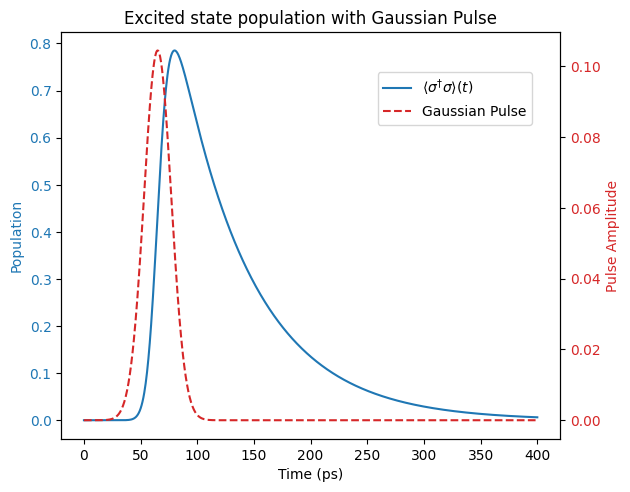

In [6]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Time (ps)')
ax1.set_ylabel('Population', color=color)
ax1.plot(tlist, TLS_populations(Δσ_0=Δσ, γσ_0=γσ, α_0=α, tau_0=τ,t_offset=t0, tlist=tlist), label='$⟨σ^{†}σ⟩(t)$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Pulse Amplitude', color=color)
ax2.plot(tlist, gaussian_pulse(tlist, α_0=α, tau_0=τ, t_offset=t0), label='Gaussian Pulse', color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Excited state population with Gaussian Pulse')
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.9))

plt.show()

# Rabi oscillations for pulse Area

In [ ]:
# Parameters
Δσ = 0
γσ = 1/65 #1/ps
tlist = np.linspace(0, 400, 1000)
taulist=tlist
Theta_values = np.pi*np.linspace(0.1, 15, 100)
τ = 10 #ps
t0=1/γσ

In [ ]:
def Rabi_PulseArea(Δσ_0, γσ_0, tau_0, t_offset, tlist, Theta_values):
    σ = destroy(2)
    H0 = Δσ_0 * σ.dag() * σ
    c_ops = [np.sqrt(γσ_0) * σ]
    psi0 = basis(2, 0)

    pulse_areas = []
    integrated_populations = []

    for Omega_0 in Theta_values:
        H1 = 1/2 * (σ.dag() + σ)
        H = [H0, [H1, lambda t, args: gaussian_pulse(t, Omega_0, tau_0, t_offset)]]
        result = mesolve(H, psi0, tlist, c_ops, [σ.dag() * σ])
        pulse_area = Omega_0 
        pulse_areas.append(pulse_area)
        integrated_population = np.trapz(result.expect[0], tlist)
        integrated_populations.append(integrated_population)

    max_population = max(integrated_populations)
    normalized_populations = [pop / max_population for pop in integrated_populations]

    return pulse_areas,normalized_populations

In [ ]:
pulse_areas, normalized_populations = Rabi_PulseArea(Δσ, γσ, τ, t0, tlist, Theta_values)

In [ ]:
plt.figure()
plt.plot(pulse_areas, normalized_populations, 'o-')
plt.xlabel('$Θ_{0}$ (π)')
plt.ylabel('Norm. Int. Excited State Population')
plt.title('Rabi Oscillations vs Pulse Area')

ticks = np.arange(0, max(pulse_areas) + np.pi, np.pi)
tick_labels = [f'{int(tick/np.pi)}π' for tick in ticks]
plt.xticks(ticks, tick_labels)


plt.show()

In [ ]:
def gaussian_pulse2_integral(Θ_0, tau_0,t_offset):
    integral = quad(lambda t: gaussian_pulse(t, Θ_0, tau_0,t_offset), -np.inf, np.inf)[0]
    return integral

# Example check
Θ_0 = 2*np.pi
tau_0 = 10
print(gaussian_pulse2_integral(Θ_0, tau_0, t0))  

# Time dependent Spectrum of emission

## Time integrated spectrum $S(ω)$

In [28]:
##2LS
Δσ=0
γσ=1/65 
tlist = np.linspace(0, 400, 300)
taulist=np.linspace(0, 400, 300)
##Gaussian_pulse parameters
α=6*np.pi
τ=12
t0=1/γσ

In [29]:
σ = destroy(2)
H0 = Δσ * σ.dag() * σ

def H1_coeff(t, args):
    return gaussian_pulse(t, α, τ, t0)
H1 = -1/2 * (σ.dag() + σ)
H = [H0, [H1, H1_coeff]]
c_ops = [np.sqrt(γσ) * σ]
psi0 = basis(2, 0)

result = mesolve(H, psi0, tlist, c_ops, [σ.dag() * σ])

In [30]:
#Non-steady state first order correlation function
G1=correlation_2op_2t(H, psi0, tlist, taulist, c_ops, σ.dag(), σ)

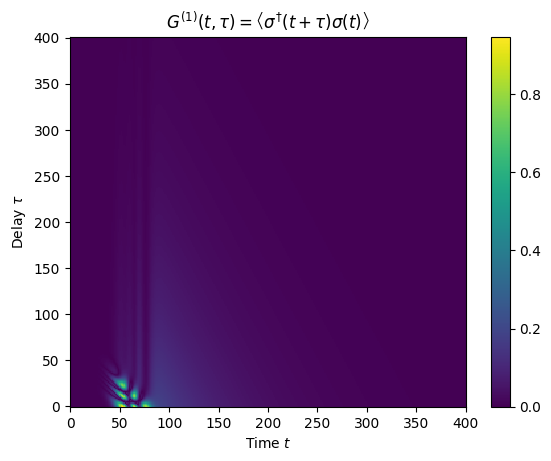

In [32]:
plt.pcolor(tlist, taulist, np.abs(G1).transpose())
plt.xlabel(r'Time $t$')
plt.ylabel(r'Delay $τ$')
plt.title(r'$G^{(1)}(t,τ)=\left<σ^{†}(t+τ)σ(t)\right>$')
plt.colorbar()
plt.show()

$S(ω)=Re\int_{0}^{∞}dt\int_{0}^{∞}dτG^{(1)}(t,τ)e^{-iωτ}$

In [33]:
G1_tau = abs(np.trapz(G1.transpose(), tlist))
#G1_tau = abs(simpson(y=G1.transpose(), x=tlist))

In [34]:
frequencies = np.fft.fftfreq(len(G1_tau), d=(tlist[1] - tlist[0]))
spectrum = np.fft.fft(G1_tau)
frequencies = np.fft.fftshift(frequencies)
spectrum = np.real(np.fft.fftshift(spectrum))

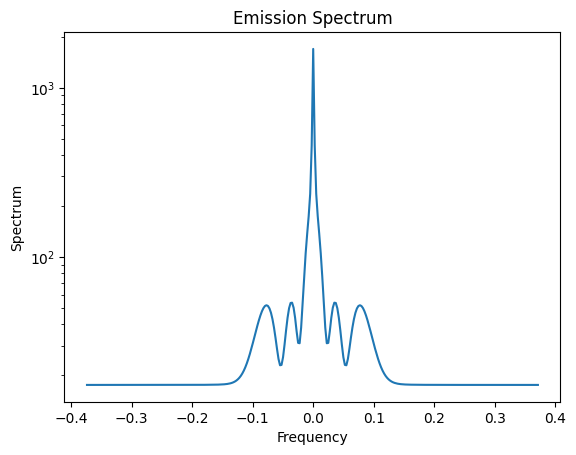

In [35]:
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.yscale('log')
plt.title('Emission Spectrum')
plt.show()

## Spectrum as a function of pulse area

In [14]:
##2LS
Δσ=0
γσ=1/65 
tlist = np.linspace(0, 400, 500)
##Gaussian_pulse parameters
τ=12
t0=1/γσ

In [16]:
def compute_spectrum(Δσ, γσ, τ, t0, α, tlist):
    σ = destroy(2)
    H0 = Δσ * σ.dag() * σ
    def H1_coeff(t, args):
        return gaussian_pulse(t, α, τ, t0)
    H1 = +1 / 2 * (σ.dag() + σ)
    H = [H0, [H1, H1_coeff]]
    c_ops = [np.sqrt(γσ) * σ]
    psi0 = basis(2, 0)
    G1 = correlation_2op_2t(H, psi0, tlist, tlist, c_ops, σ.dag(), σ)
    G1_tau = abs(np.trapz(G1.transpose(), tlist))
    frequencies = np.fft.fftfreq(len(G1_tau), d=(tlist[1] - tlist[0]))
    spectrum = np.fft.fft(G1_tau)
    frequencies = np.fft.fftshift(frequencies)
    spectrum = np.real(np.fft.fftshift(spectrum))
    return frequencies, spectrum

In [17]:
spectra = []
pulse_areas = np.pi * np.linspace(0, 15, 101)
for Theta in pulse_areas:
    _, spectrum = compute_spectrum(Δσ, γσ, τ, t0, Theta, tlist)
    spectra.append(spectrum)

spectra = np.array(spectra)

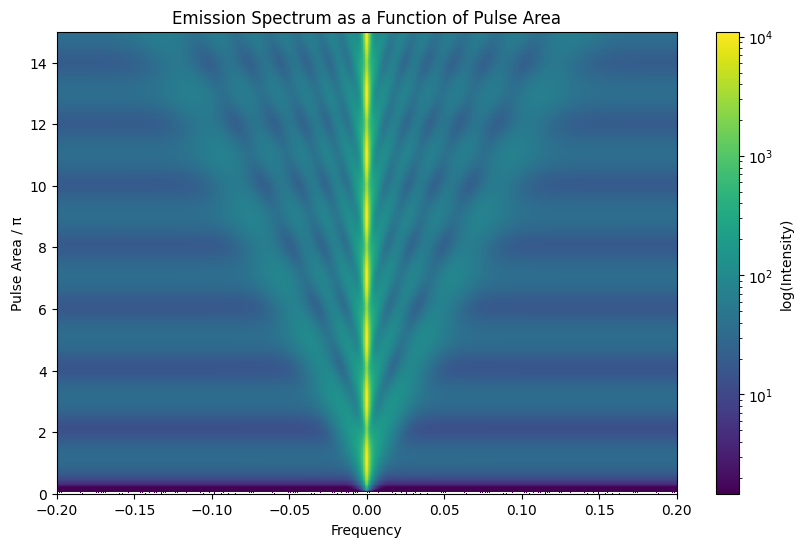

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(spectra, aspect='auto', extent=[frequencies[0], frequencies[-1], pulse_areas[-1]/np.pi, pulse_areas[0]/np.pi], cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='log(Intensity)')
plt.xlabel('Frequency')
plt.ylabel('Pulse Area / π')
plt.xlim(-0.2,0.2)
plt.title('Emission Spectrum as a Function of Pulse Area')
plt.gca().invert_yaxis()
plt.show()

# Second order correlation function

In [38]:
##2LS
Δσ=0
γσ=1/65
tlist = np.linspace(0, 400, 300)
taulist=np.linspace(0, 400, 300)
##Gaussian_pulse parameters
α=10*np.pi
τ=12
t0=1/γσ

In [ ]:
σ = destroy(2)
H0 = Δσ * σ.dag() * σ

def H1_coeff(t, args):
    return gaussian_pulse(t, α, τ, t0)
H1 = -1/2 * (σ.dag() + σ)
H = [H0, [H1, H1_coeff]]
c_ops = [np.sqrt(γσ) * σ]
psi0 = basis(2, 0)

result = mesolve(H, psi0, tlist, c_ops, [σ.dag() * σ])

In [ ]:
#Non-steady state second order correlation function
G2=correlation_3op_2t(H, psi0, tlist, taulist, c_ops, σ.dag(),σ.dag() * σ, σ)
nσ=result.expect[0] 

In [ ]:
plt.pcolor(tlist, taulist, np.abs(G2).transpose())
plt.xlabel(r'Time $t$')
plt.ylabel(r'Delay $τ$')
plt.title(r'$G^{(2)}(t,τ)=\left<σ^{†}(t)σ^{†}(t+τ)σ(t+τ)σ(t)\right>$')
plt.colorbar()
plt.show()

In [ ]:
nσ_int= abs(np.trapz(nσ, tlist))
G2_tau = abs(np.trapz(G2.transpose(), tlist))

In [ ]:
plt.plot(tlist*γσ, G2_tau)
plt.xlabel('τ [1/γ]')
plt.ylabel('$G^{(2)}(\\tau)$')
#plt.xlim(-0.1, 0.1)
plt.title('Integrated second order correlation function')
plt.show()

In [39]:
def G2SS_Solver(α, τ, t0,  Δσ, γσ, tlist, taulist):
    σ = destroy(2)
    c_ops = [np.sqrt(γσ) * σ]
    Hσ0 = Δσ * σ.dag() * σ
    Hσ1 = 1/2 * (σ.dag() + σ)
    H1_coeff = lambda t, args: gaussian_pulse(t, α, τ, t0)
    H = [Hσ0, [Hσ1, H1_coeff]]

    L0 = liouvillian(H[0], c_ops)
    L_td = [L0 , [liouvillian(Hσ1), H1_coeff]]
    psi0 = basis(2, 0)
    G2σ=correlation_3op_2t(L_td, psi0, tlist, taulist, [], σ.dag(),σ.dag() * σ, σ)
    G2σ_tau = abs(np.trapz(G2σ.transpose(), tlist))
    G2σ_zero= 2*abs(np.trapz(G2σ_tau.transpose(), taulist))
    result = mesolve(L_td, psi0, tlist, [], [σ.dag() * σ])
    nσ_t = result.expect[0]
    int_nσ= abs(np.trapz(nσ_t, tlist))
    return G2σ_zero/(int_nσ ** 2)

In [45]:
Δα_values = np.pi*np.linspace(1,6,81)
g2σ_alpha_values = np.zeros((len(Δα_values)))

In [46]:
for i, α0 in enumerate(Δα_values):
        print(i)
        g2σ_alpha_values[i] = G2SS_Solver(α0, τ, t0,  Δσ, γσ, tlist, taulist)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [48]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Δα_values / np.pi,
    y=g2σ_alpha_values,
    mode='lines',
    name='$g^{(2)}[0]$',
    line=dict(color='blue', width=2)
))

fig.update_layout(
    title='$\\omega_a,\\omega_b=\\alpha$',
    xaxis=dict(
        title='Pulse area $(\\pi)$',
        showline=True,
        linecolor='black',
        linewidth=1.2,
        mirror=True
    ),
    yaxis=dict(
        title='$g^{(2)}[0]$',
        showline=True,
        linecolor='black',
        linewidth=1.2,
        mirror=True
    ),
    font=dict(
        family="Garamond",
        size=20,
        color="black"
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()